In [1]:
# import usual libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import f1_score

# our system imports
from aideme import *

%matplotlib inline

In [2]:
def plot_fscore(metrics):
    df_list = [pd.DataFrame.from_dict({i: metric for i, metric in enumerate(ls)}, orient='index') for ls in metrics]
    avg = sum([df['fscore'][~df['fscore'].isna()] for df in df_list]) / len(df_list)
    avg.plot(ylim=[0,1], marker='o')
    plt.show()


def train_score(dataset, active_learner):
    X_train, y_train = dataset.training_set()
    y_pred = active_learner.predict(X_train)
    return {'train_score': f1_score(y_train, y_pred)}

In [3]:
# DUMMY DATA
N = int(2e4)
dim = 2
PARTITION = [[0], [1]]  #[[0, 1], [2, 3], [4], [5]]
limit = 2 * (0.001) ** (1/dim) #0.06 #0.63
rng = np.random.RandomState(0)
X = rng.uniform(low=-2, high=2, size=(N, dim))  # do not forget to standardize the data. For this distribution, it should be fine without it.
y_subspace = np.vstack([np.all(np.abs(X[:, p]) < limit, axis=1) for p in PARTITION]).T.astype('float')  # partial labels (for each subspace)
y = y_subspace.min(axis=1)

labeled_set = LabeledSet(y, y_subspace)

# visualize data distribution
print('selectivity :', 100 * y.sum() / len(y), '%')

#plt.figure(figsize=(10,8))
#plt.scatter(X[:, 0], X[:, 1], s=0.05, c=['b' if lb else 'r' for lb in y])
#plt.show()

selectivity : 0.075 %


In [6]:
# SET-UP EXPLORATION CONFIGURATION
REPEAT = 1
NUMBER_OF_ITERATIONS = 60  # number of points to be labeled by the user

SUBSAMPLING = None 

INITIAL_SAMPLER = stratified_sampler(labeled_set, pos=1, neg=1)

CALLBACK = [
    classification_metrics(X, labeled_set.labels, ['fscore']), 
]

CALLBACK_SKIP = 4


CONVERGENCE_CRITERIA = [
    max_iter_reached(NUMBER_OF_ITERATIONS),
]


SEED = list(range(REPEAT))

explore = PoolBasedExploration(INITIAL_SAMPLER, SUBSAMPLING, CALLBACK, CALLBACK_SKIP, CONVERGENCE_CRITERIA)


learners = {
    #'default': KernelVersionSpace(n_samples=8, warmup=100, thin=10, rounding_cache=False, rounding_options={'strategy': 'default'}),
    #'opt + z_cut': KernelVersionSpace(n_samples=16, warmup=100, thin=100, rounding_cache=True, rounding_options={'strategy': 'opt', 'z_cut': True, 'sphere_cuts': False}),
    'opt + z_cut + sphere': KernelVersionSpace(n_samples=16, warmup=100, thin=100, rounding_cache=True, rounding_options={'strategy': 'opt', 'z_cut': False, 'sphere_cuts': True}),
}

avg = {}

for lb, learner in learners.items():
    dfs = []
    
    i = 0
    for run in explore.run(X, labeled_set, learner, repeat=REPEAT, seeds=SEED):
        i += 1
        dfs.append(pd.DataFrame(run))
        print('Finished run {} of learner {}'.format(i, lb))

    avg[lb] = sum([df[['fscore', 'iter_time', 'rounding_sphere_opt_calls']].loc[~df['fscore'].isnull()] for df in dfs]) / len(dfs)

Finished run 1 of learner opt + z_cut + sphere


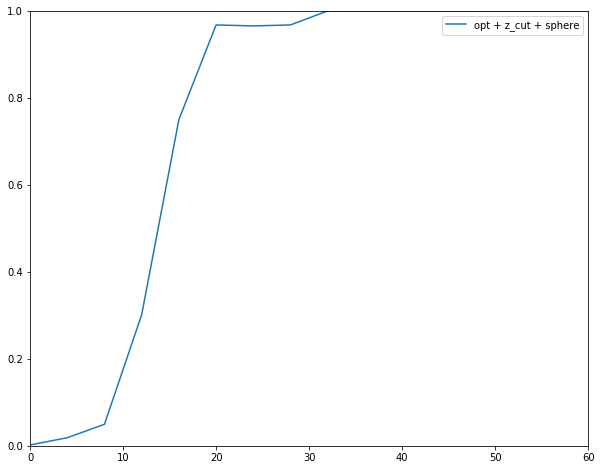

In [8]:
m = 'fscore'
#m = 'iter_time'
#m = 'rounding_sphere_opt_calls'

plt.figure(figsize=(10, 8))

for lb, metrics in avg.items():
    metrics[m].plot(label=lb)

if m == 'fscore':
    plt.ylim([0, 1])
plt.xlim([0, max(metrics.index)])
plt.legend(loc='best')

In [ ]:
############################ SDSS Q1 RESULTS ############################

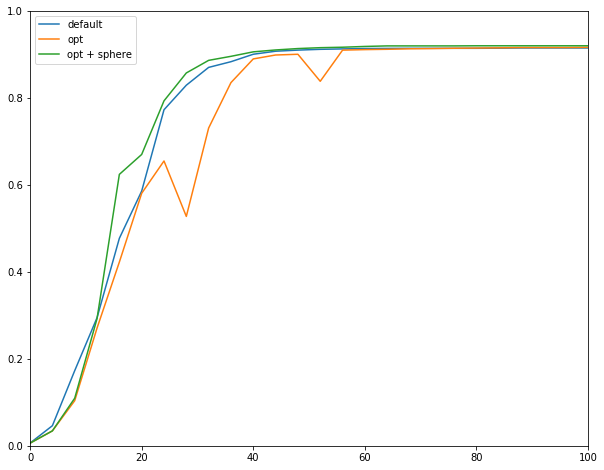

In [18]:
m = 'fscore'
#m = 'iter_time'

plt.figure(figsize=(10, 8))

for lb, metrics in avg.items():
    metrics[m].plot(label=lb)

if m == 'fscore':
    plt.ylim([0, 1])
plt.xlim([0, max(metrics.index)])
plt.legend(loc='best')

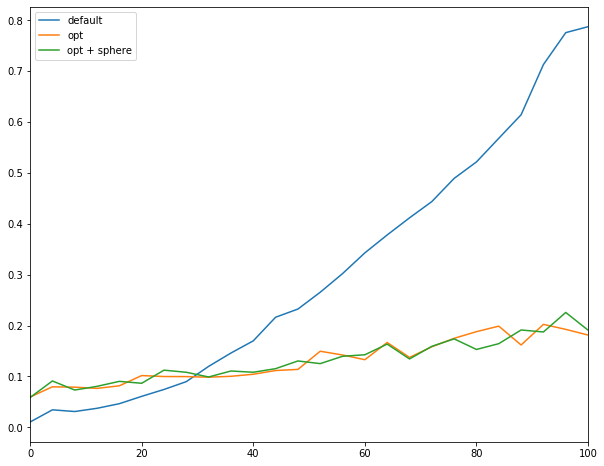

In [19]:
#m = 'fscore'
m = 'iter_time'

plt.figure(figsize=(10, 8))

for lb, metrics in avg.items():
    metrics[m].plot(label=lb)

if m == 'fscore':
    plt.ylim([0, 1])
plt.xlim([0, max(metrics.index)])
plt.legend(loc='best')